<a href="https://colab.research.google.com/github/MadmanMarble/Planet_U-NET/blob/main/Planet_training_U_Net_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U segmentation-models

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical
import segmentation_models as sm
import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install rasterio

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split
import shutil
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
import random

### read one file

384 384 5


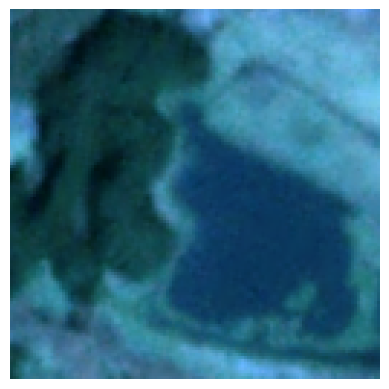

In [6]:
with rasterio.open(r'/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/1131_planet_stack_utm4.tif') as src:
  temp_img = src.read()

print(src.height, src.width, src.count)

temp_img = temp_img[:3, :, :].transpose(1, 2, 0)

temp_img_norm = temp_img /np.max(temp_img)
plt.imshow(temp_img_norm)
plt.axis('off')
plt.show()

384 384 1
Labels are:  [ 2.  3. 10.] and the counts are: [45505 97547  4404]


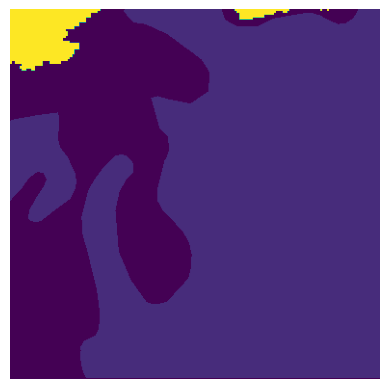

In [7]:
with rasterio.open(r'/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/1131_nwi_ccap_filled_utm4.tif') as src:
  temp_mask = src.read(1)

print(src.height, src.width, src.count)

# what labels are in this file?
labels, count = np.unique(temp_mask, return_counts=True)
print("Labels are: ", labels, "and the counts are:", count)

plt.imshow(temp_mask)
plt.axis('off')
plt.show()

In [8]:
root_directory = "/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/"

### Code for splitting folder into training, validation

In [9]:
# Ensure the lists are sorted so that images and labels correspond to each other
planet_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/*.tif"))
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/*.tif"))

# Split the file paths into training, validation, and testing sets (80% train, 20% validation)
train_img, val_img, train_label, val_labels, = train_test_split(
    planet_images, planet_labels, test_size = 0.2, random_state = 42)

In [10]:
train_img_dir = train_img
train_label_dir = train_label
val_img_dir = val_img
val_label_dir = val_labels
print(len(train_img_dir))
print(len(train_label_dir))
print(len(val_img_dir))
print(len(val_label_dir))

2260
2260
565
565


In [11]:
img_num = random.randint(0, len(train_img_dir))

Labels are:  [ 1.  4.  5.  6.  7.  8.  9. 10. 11.] and the counts are: [  977   163   827  4574 31103 23827  9082 21454 55449]


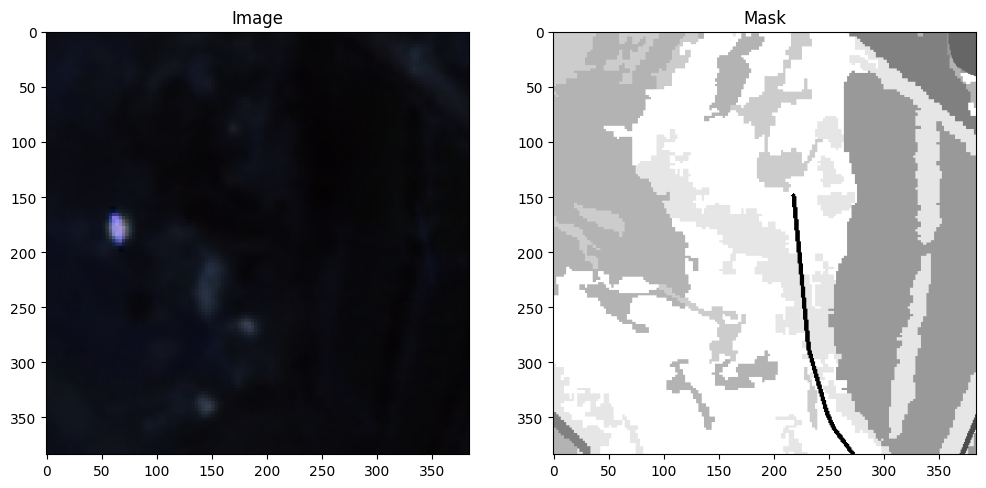

In [12]:
img_for_plot = rasterio.open(train_img_dir[img_num])
img_for_plot = img_for_plot.read()
img_for_plot = img_for_plot[:3, :, :].transpose(1, 2, 0)
img_for_plot_norm = img_for_plot /np.max(img_for_plot)

label_for_plot = rasterio.open(train_label_dir[img_num])
label_for_plot = label_for_plot.read(1)

labels, count = np.unique(label_for_plot, return_counts=True)
print("Labels are: ", labels, "and the counts are:", count)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot_norm)
plt.title('Image')
plt.subplot(122)
plt.imshow(label_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [48]:
seed = 24
batch_size = 16
n_classes = 13
SIZE_X = 384
SIZE_Y = 384
IMG_CHANNELS = 5

In [14]:
# BACKBONE = 'resnet34'
# preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# def preprocess_data(img, mask, num_class):
#     #Scale images
#     img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
#     img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
#     #Convert mask to one-hot
#     mask = to_categorical(mask, num_class)

#     return (img,mask)

In [17]:
# # Ensure the lists are sorted so that images and labels correspond to each other
# planet_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/*.tif"))
# planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/*.tif"))

# # Split the file paths into training, validation, and testing sets (80% train, 20% validation)
# train_img, val_img, train_label, val_labels, = train_test_split(
#     planet_images, planet_labels, test_size = 0.2, random_state = 42)

# train_img_dir = train_img
# train_label_dir = train_label
# val_img_dir = val_img
# val_label_dir = val_labels

In [ ]:
# List of files to copy
# files_to_copy = ['path/to/source/file1.txt', 'path/to/source/file2.jpg', 'path/to/source/file3.pdf']
destination = '/content/train_images'
os.makedirs(destination, exist_ok=True)
for file in train_img:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

destination = '/content/train_labels'
os.makedirs(destination, exist_ok=True)
for file in train_label:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

destination = '/content/val_images'
os.makedirs(destination, exist_ok=True)
for file in val_img:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

destination = '/content/val_labels'
os.makedirs(destination, exist_ok=True)
for file in val_labels:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

In [16]:
# #Define the generator.
# #We are not doing any rotation or zoom to make sure mask values are not interpolated.
# #It is important to keep pixel values in mask as 0, 1, 2, 3, .....
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# def trainGenerator(train_img_path, train_mask_path, num_class):

#     img_data_gen_args = dict(horizontal_flip=True,
#                       vertical_flip=True,
#                       fill_mode='reflect')

#     image_datagen = ImageDataGenerator(**img_data_gen_args)
#     mask_datagen = ImageDataGenerator(**img_data_gen_args)

#     image_generator = image_datagen.flow_from_directory(
#         train_img_path,
#         class_mode = None,
#         batch_size = batch_size,
#         seed = seed)

#     mask_generator = mask_datagen.flow_from_directory(
#         train_mask_path,
#         class_mode = None,
#         color_mode = 'grayscale',
#         batch_size = batch_size,
#         seed = seed)

#     train_generator = zip(image_generator, mask_generator)

#     for (img, mask) in train_generator:
#         img, mask = preprocess_data(img, mask, num_class)
#         yield (img, mask)


In [25]:


train_img_path = sorted(glob.glob(f"/content/train_images/*.tif"))
train_mask_path = sorted(glob.glob(f"/content/train_labels/*.tif"))

val_img_path = sorted(glob.glob(f"/content/val_images/*.tif"))
val_mask_path = sorted(glob.glob(f"/content/val_labels/*.tif"))

print(len(train_img_path))
print(len(train_mask_path))
print(len(val_img_path))
print(len(val_mask_path))

2260
2260
565
565


In [23]:
from tensorflow.keras.utils import Sequence

In [43]:
class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image


    # def z_score_normalization(self, image):
    #     # epsilon = 1e-7
    #     # mean = np.mean(image, axis=(0, 1), keepdims=True)
    #     # std = np.std(image, axis=(0, 1), keepdims=True)
    #     # std[std < 0] = 0
    #     # normalized_image = (image - mean) / (std + epsilon)
    #     min = np.min(image, axis=(0, 1), keepdims=True)
    #     max = np.max(image, axis=(0, 1), keepdims=True)
    #     normalized_image = (image - min) / (max - min)
    #     return normalized_image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges

        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val

        # Avoid division by zero by checking if range is 0
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val

        return normalized_image


# data = np.random.normal(loc=0, scale=1, size=(96108, 7, 7))
# data_min = np.min(data, axis=(1,2), keepdims=True)
# data_max = np.max(data, axis=(1,2), keepdims=True)

# scaled_data = (data - data_min) / (data_max - data_min)

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]

        # Apply Z-score normalization to images
        normalized_images = [self.z_score_normalization(image) for image in images]

        # Process labels if necessary (for example, converting to categorical)
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]

        return np.array(normalized_images), np.array(processed_labels)

In [44]:
train_data_generator = DataGenerator(train_img_path, train_mask_path, SIZE_X, SIZE_Y, batch_size, n_classes)
val_data_generator = DataGenerator(val_img_path, val_mask_path, SIZE_X, SIZE_Y, batch_size, n_classes)

# print(len(train_img_path))
# print(len(train_mask_path))
# print(len(val_img_path))
# print(len(val_mask_path))

# train_img_path = "/content/train_images/"
# train_mask_path = "/content/train_labels/"
# train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=13)

# val_img_path = "/content/val_images/"
# val_mask_path = "/content/val_labels/"
# val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=13)



In [45]:
# #Make sure the generator is working and that images and masks are indeed lined up.
# #Verify generator.... In python 3 next() is renamed as __next__()
# x, y = train_img_gen.__next__()
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [41]:
print(batch_images.shape)
print(batch_labels.shape)

(16, 384, 384, 5)
(16, 384, 384, 13)


In [46]:
batch_images

array([[[[0.        , 0.        , 0.        , 0.        , 0.69213974],
         [0.        , 0.        , 0.        , 0.        , 0.7161738 ],
         [0.        , 0.        , 0.        , 0.        , 0.7161738 ],
         ...,
         [0.        , 0.        , 0.        , 0.        , 0.9302026 ],
         [0.        , 0.        , 0.        , 0.        , 0.9302026 ],
         [0.        , 0.        , 0.        , 0.        , 0.9302026 ]],

        [[0.        , 0.        , 0.        , 0.        , 0.68865395],
         [0.        , 0.        , 0.        , 0.        , 0.71369284],
         [0.        , 0.        , 0.        , 0.        , 0.71369284],
         ...,
         [0.        , 0.        , 0.        , 0.        , 0.9094347 ],
         [0.        , 0.        , 0.        , 0.        , 0.9094347 ],
         [0.        , 0.        , 0.        , 0.        , 0.9094347 ]],

        [[0.        , 0.        , 0.        , 0.        , 0.68865395],
         [0.        , 0.        , 0.        ,

In [47]:
batch_labels

array([[[[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
    

In [50]:
# def multi_unet_model(n_classes=13, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=5):
# #Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
#     s = inputs

#     #Contraction path
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#     #Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#     outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])

#     #NOTE: Compile the model in the main program to make it easy to test with various loss functions
#     #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     #model.summary()

# model.summary() # 1,941,597

#     return model

In [64]:

from keras.utils import to_categorical
import keras
# import TenserFlow classes and functions
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

In [66]:
def multi_unet_model(n_classes=13, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=5):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(n_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [68]:
model = multi_unet_model()

In [69]:
model.summary() #    2,062,445

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 5)]        0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 192, 192, 32)         1472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 192, 192, 32)         128       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 192, 192, 32)         0         ['batch_normalization_15

In [70]:
print(model.input_shape)

(None, 384, 384, 5)


In [55]:
from tensorflow.keras.callbacks import Callback
import numpy as np

In [56]:
# class SaveValidationData(Callback):
#     def __init__(self, validation_data, filename, save_every=5):
#         super(SaveValidationData, self).__init__()
#         self.validation_data = validation_data
#         self.filename = filename
#         self.save_every = save_every

#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch + 1) % self.save_every == 0:
#             validation_data = np.asarray(self.validation_data)
#             np.savetxt(self.filename.format(epoch=epoch), validation_data, delimiter=',')
#             print(f"Validation data saved at epoch {epoch}.")

In [62]:
from tensorflow.keras.optimizers import Adam

In [72]:
# Usage:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/DeepLearning_Project/Models/Spatial_experiments/Control_pixels/OneYear_model_002_lr001.h5', save_best_only=True)]


In [58]:
# Instantiate the custom callback
# save_validation_callback = SaveValidationData(validation_data=val_data_generator, filename='/content/validation_data_epoch_{epoch}.csv', save_every=5)

In [73]:
# Train the model with the callback
model.fit(train_data_generator, validation_data=val_data_generator, callbacks=[callbacks], epochs=100)


Epoch 1/100
142/142 [==============================] - 223s 1s/step - loss: 2.5875 - accuracy: 0.3121 - val_loss: 2.1624 - val_accuracy: 0.2126
Epoch 2/100
142/142 [==============================] - 194s 1s/step - loss: 1.8458 - accuracy: 0.3804 - val_loss: 2.0880 - val_accuracy: 0.2097
Epoch 3/100
142/142 [==============================] - 185s 1s/step - loss: 1.7798 - accuracy: 0.4102 - val_loss: 1.9405 - val_accuracy: 0.2741
Epoch 4/100
142/142 [==============================] - 193s 1s/step - loss: 1.7318 - accuracy: 0.4082 - val_loss: 1.7696 - val_accuracy: 0.3839
Epoch 5/100
142/142 [==============================] - 186s 1s/step - loss: 1.7153 - accuracy: 0.4135 - val_loss: 1.7222 - val_accuracy: 0.4410
Epoch 6/100
142/142 [==============================] - 187s 1s/step - loss: 1.6668 - accuracy: 0.4385 - val_loss: 1.7700 - val_accuracy: 0.4237
Epoch 7/100
142/142 [==============================] - 181s 1s/step - loss: 1.7163 - accuracy: 0.4129 - val_loss: 1.8099 - val_accuracy:

KeyboardInterrupt: 